In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Scikit-learn

- [Scikit-learn glossary](https://scikit-learn.org/stable/glossary.html)
- [Scikit-learn MOOC](https://inria.github.io/scikit-learn-mooc/)

## Pipilines and model diagrams with `make_pipeline`

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# to display nice model diagram
from sklearn import set_config
set_config(display='diagram')

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Preprocessing

### Preprocessing pipeline with `ColumnTransformer` and selecting features based on their column type with `make_column_selector`

Use pipelines to write efficient code and reduce the risk of data leakage and encode multiple categorical variables at once with `ColumnTransformer`:

In [ ]:
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)
])

model = make_pipeline(preprocessor, LogisticRegression())

### Encoding of categorical variables

#### Ordinal categories with `OrdinalEncoder`

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=["S", "M", "L", "XL"])
data_encoded = encoder.fit_transform(data[["size"]])

#### Nominal categories with `OneHotEncoder` (without assuming any order)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
data_encoded = encoder.fit_transform(data_categorical)

columns_encoded = encoder.get_feature_names_out(data_categorical.columns)
data_encoded = pd.DataFrame(data_encoded, columns=columns_encoded)

### Split dataset with `train_test_split` (and example of using pipelines)

Use `stratify` attrbute for inbalanced classes

In [16]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load data
cars = (
    pd.read_csv("../_data/cars_dataset.csv")
    .rename(str.lower, axis="columns")
    .loc[lambda df: df["cylinders"] > 3]
    .dropna()
    .assign(year=lambda df: df["year"].str.slice(0,4).astype('int'))
)

feature_columns = ["miles_per_gallon", "cylinders", "displacement", "horsepower", "acceleration", "year", "origin"]

X = cars[feature_columns]
y = cars["weight_in_lbs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

# Define model
categorical_columns = ["origin"]

ct = ColumnTransformer(
    [
    ("onehot", OneHotEncoder(drop="first", handle_unknown="error"), categorical_columns)
    ], remainder="passthrough") 

model = Pipeline(steps=[
      ("encoding", ct),
      ("scaler", StandardScaler()),
      ("estimator", GradientBoostingRegressor())
])

# Train model
model.fit(X_train, y_train)

# Make predictions
y_pred  = model.predict(X_test)

# Evaluate results
r2 = r2_score(y_test, y_pred).round(3)
mae = mean_absolute_error(y_test, y_pred).round(3)

print(f"R2: {r2}")
print(f"MAE: {mae}")

R2: 0.934
MAE: 144.944


## Custom classes

### Template for custom transformer with `BaseEstimator` and `TransformerMixin`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, my_arg):
        # super().__init__() --> use __init__() of parent class, in this case not needed as BaseEstimator does not have init method
        self.my_arg = my_arg
        
    def fit(self, X, y=None):
        self.my_param_ = ... # trailing _ to indicate that parameter is set during fitting/training
        return self
    
    def transform(self, X):
        X_transformed = ...
        return X_transformed

### Template for custom estimator with `BaseEstimator`

In [ ]:
from sklearn.base import BaseEstimator

class CustomEstimator(BaseEstimator):
    
    def __init__(self, my_arg):
        # super().__init__() --> use __init__() of parent class, in this case not needed as BaseEstimator does not have init method
        self.my_arg = my_arg
        
    def fit(self, X, y=None, **fit_params):
        estimator = ...
        self.estimator_ = estimator.fit(X, y=y)  # trailing _ to indicate that parameter is set during fitting/training
        return self
    
    def predict(self, X, **predict_params):
        check_is_fitted(self, ["estimator_"])
        return self.estimator_.predict(X)

## Models

### Visualise decision tree with `plot_tree`

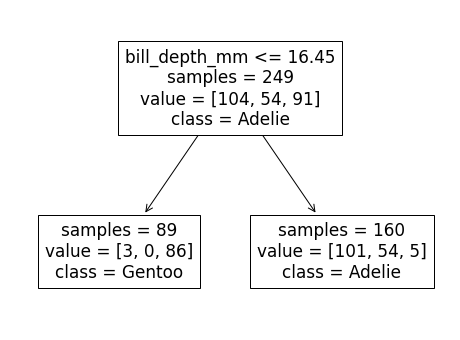

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

penguins = pd.read_csv("../_data/penguins_dataset.csv").dropna()
culmen_columns = ["bill_length_mm", "bill_depth_mm"]
target_column = "species"

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(tree, feature_names=culmen_columns,
              class_names=tree.classes_, impurity=False, ax=ax)

### Predict label with `predict()` or probability with `predict_proba()` or score with `score()`

In [17]:
sample = pd.DataFrame(
    {"bill_length_mm": [0], "bill_depth_mm": [15]}
)

tree.predict(sample)

array(['Gentoo'], dtype=object)

<AxesSubplot:>

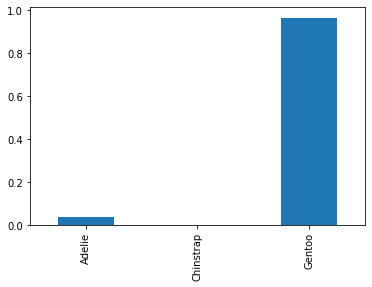

In [18]:
y_pred_proba = tree.predict_proba(sample)

y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)
y_proba_class_0.plot.bar()

In [21]:
y_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {y_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.76


## Model evaluation

### Cross validation with `cross_val_score` and `cross_validate`

In [ ]:
from sklearn.model_selection import cross_val_score

# Basic cv
cv = KFold(n_splits=5, shuffle=False)

# Bootstrapping cv
cv = ShuffleSplit(n_splits=2,  test_size=0.2, random_state=0)

test_scores = cross_val_score(model, data, target, cv=cv)

In [ ]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, y)

scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: {scores.mean():.3f} +/- {scores.std():.3f}")

### Hyperparameter tuning with nested cross-validation

With **nested cross-validation**, we use an inner
cross-validation for the selection of the hyperparameters and an outer
cross-validation for the evaluation of generalization performance of the
refitted tuned model.

1. Define preprocessing steps

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [
        ('cat_preprocessor', categorical_preprocessor, categorical_columns),
    ],
    remainder='passthrough',
    sparse_threshold=0,
)

2. Define model pipeline

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    (
        "classifier",
        HistGradientBoostingClassifier(
            random_state=42, max_leaf_nodes=4
        )
    ),
])

3. Define hyperparameter tuning with grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.05, 0.5),
    'classifier__max_leaf_nodes': (10, 30),
}
model_grid_search = GridSearchCV(
    model, param_grid=param_grid, n_jobs=2, cv=2
)

5. Perform netsted cross validation

In [ ]:
cv_results = cross_validate(
    model_grid_search, data, target, cv=5, n_jobs=2, return_estimator=True
)


6. Check model generalization performance

In [ ]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} +/- {cv_test_scores.std():.3f}"
)

7. In addition, passing the parameter `return_estimator=True`, we can check the
value of the best hyperparameters obtained for each fold of the outer
cross-validation.

In [ ]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Here is a schematic representation of the complete nested cross-validation
procedure:

![Nested cross-validation
diagram](../_images/nested_cross_validation_diagram.png)

## Other best practices

- Model parameters (scikit-learn convention): if an attribute is learned from the data, its name ends with an underscore (i.e. `_`), as in `mean_` and `scale_` for the `StandardScaler`.
- [scikit-lego](https://scikit-lego.readthedocs.io/en/latest/) repository for custom models not in scikit-learn by default
